# Non-parametric estimation of Value-at-Risk and Expected Shortfall
## Historical simulation
We need some data, the file sp500.csv contains daily value weighted returns of the SP500 index from 1990-2020.
Typically we work with returns (or -returns, that is, losses) and multiply the %VaR or %ES to a dollar value in the end by multiplying with the value of the portfolio

In [1]:
#Import packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import math as m
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt


In [2]:
# Read CSV file
filename='sp500.csv'
table = pd.read_csv(filename)
table.head()

,caldt,vwretd
0,1990-01-02,0.017527
1,1990-01-03,-0.002028
2,1990-01-04,-0.007913
3,1990-01-05,-0.010069
4,1990-01-08,0.004798


In [3]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7812 entries, 0 to 7811
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   caldt   7812 non-null   object 
 1   vwretd  7812 non-null   float64
dtypes: float64(1), object(1)
memory usage: 122.2+ KB


In [4]:
# So python does not "know" that the dates are dates (object is string)
table['caldt'] = pd.to_datetime(table['caldt'])
dates = table['caldt'] # we will need these later
table.info()
# but the dates are still not the index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7812 entries, 0 to 7811
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   caldt   7812 non-null   datetime64[ns]
 1   vwretd  7812 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 122.2 KB


In [5]:
table = table.set_index('caldt')
table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7812 entries, 1990-01-02 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vwretd  7812 non-null   float64
dtypes: float64(1)
memory usage: 122.1 KB


If we want the last five years of data we can look at the table and see what index to use, but it is more convenient to use a date range directly as index.


In [6]:
start = dt.datetime(2016, 1, 1)
end = dt.datetime(2020,12,31)
our_sample = table[start:end]
print(our_sample)

              vwretd
caldt               
2016-01-04 -0.015190
2016-01-05  0.002134
2016-01-06 -0.012566
2016-01-07 -0.023433
2016-01-08 -0.010898
...              ...
2020-12-24  0.003623
2020-12-28  0.008938
2020-12-29 -0.002240
2020-12-30  0.001475
2020-12-31  0.006367

[1259 rows x 1 columns]


### Basic Historical Simulation (BHS)
Now we will compute a 99% VaR and ES forecast for January 2nd 2021 using the whole 5 year sample. Note that VaR and ES are constant with BHS. We start by doing this "manually"


In [7]:
alpha = 0.99 # VaR/ES Level
our_sample['losses'] = our_sample['vwretd']*-1 # Don't forget the minus sign if we want the loss distribution
sorted_losses = our_sample.sort_values('losses', ascending=False)
print(sorted_losses)

              vwretd    losses
caldt                         
2020-03-16 -0.118970  0.118970
2020-03-12 -0.095036  0.095036
2020-03-09 -0.075275  0.075275
2020-06-11 -0.058263  0.058263
2020-03-18 -0.050477  0.050477
...              ...       ...
2020-03-17  0.060242 -0.060242
2020-03-26  0.062088 -0.062088
2020-04-06  0.070015 -0.070015
2020-03-24  0.092646 -0.092646
2020-03-13  0.093205 -0.093205

[1259 rows x 2 columns]


In [8]:
T =  len(sorted_losses.index)# Get the number of returns
idx = m.floor((1-alpha)*T+1) # Calculate the index on the ordered data 
                           # that is our VaR (see formula on slide 6 of Non-parametric methods video)
print(sorted_losses.iloc[idx-1,1]) # we need iloc because we pick the row number not the index (which is a date)
                                   # -1 since first index is 0
print("On a 1000 USD portfolio we expect to lose less than {:.1f} USD 99% of the time".format(sorted_losses.iloc[idx-1,1]*1000))

0.035198
On a 1000 USD portfolio we expect to lose less than 35.2 USD 99% of the time


In [9]:
es_99 = np.mean(sorted_losses.iloc[:idx-1,1]) # ES as mean of loss larger than VaR
print(sorted_losses.iloc[:idx-1,1]) # note that idx-1 actually excludes the VaR return
print("99% Expected Shortfall is {:.1f} USD".format(es_99*1000))

caldt
2020-03-16    0.118970
2020-03-12    0.095036
2020-03-09    0.075275
2020-06-11    0.058263
2020-03-18    0.050477
2020-03-11    0.048751
2020-02-27    0.043781
2020-04-01    0.043645
2020-03-20    0.043187
2018-02-05    0.040869
2018-02-08    0.037319
2016-06-24    0.035723
Name: losses, dtype: float64
99% Expected Shortfall is 57.6 USD


An alternative is to use the quantile function

In [10]:
VaR_99_alt = np.quantile(our_sample['losses'],alpha)
# % Not exactly same since quantile uses linear interpolation
print("Percentage VaR {:.4f} %".format(VaR_99_alt*100))

Percentage VaR 3.5057 %


You can also compute ES, after having computed VaR without sorting

In [11]:
es_99_alt = np.mean(our_sample.loc[our_sample['losses']>VaR_99_alt,'losses'])
print(es_99_alt)

0.05588415384615385


## Time variation
BHS has no time variation if the whole sample is used. To induce time variation it is common to do BHS on a rolling sample. Say we want 95% VaR one day ahead on a rolling sample of 250 returns.

In [12]:
rT = 250 # Size of rolling sample

our_sample.insert(2,"VaR",np.nan)

for j in range(rT,T): # Pick j from 250 up to T
    roll_sample = our_sample.iloc[j-(rT):j,1]
    our_sample.iloc[j,2] = np.quantile(roll_sample,0.95)
    


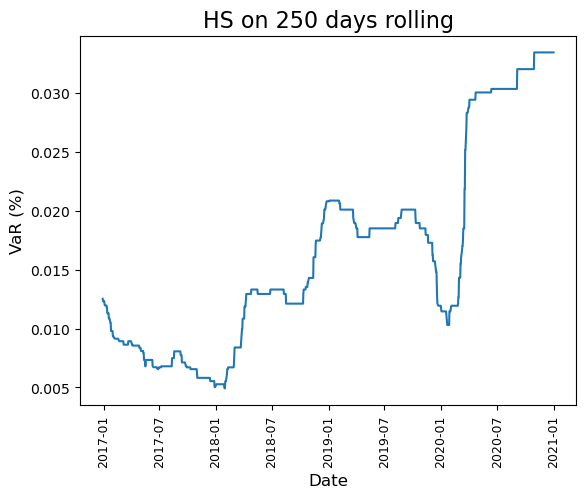

In [13]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.plot(our_sample['VaR'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('VaR (%)',fontsize=12)
plt.title('HS on 250 days rolling',fontsize=16)
ax.tick_params(axis='x',labelrotation=90,labelsize=9)



One problem with rolling estimation of VaR is that you need a pretty short window to get VaR to respond to new market conditions fast but you need a pretty long windows to have any precision in your estimate

In [14]:
vix_df = pd.read_csv("VIX.csv") # Data from Yahoo finance
print(vix_df)

            Date   VIX Open
0     1990-01-02  17.240000
1     1990-01-03  18.190001
2     1990-01-04  19.219999
3     1990-01-05  20.110001
4     1990-01-08  20.260000
...          ...        ...
8033  2021-11-17  16.360001
8034  2021-11-18  16.809999
8035  2021-11-19  17.360001
8036  2021-11-22  18.200001
8037  2021-11-23  20.240000

[8038 rows x 2 columns]


We will first set the dates as index also for the VIX index datafram. Using a time index is great for matching observations from different data sources, sometimes Yahoo e.g. have dates in the sample that WRDS do not, then you cannot simply match by adding a new column because dates would be off.


In [15]:
vix_df['Date'] = pd.to_datetime(vix_df.iloc[:,0])
vix_df = vix_df.set_index('Date')
print(vix_df)


             VIX Open
Date                 
1990-01-02  17.240000
1990-01-03  18.190001
1990-01-04  19.219999
1990-01-05  20.110001
1990-01-08  20.260000
...               ...
2021-11-17  16.360001
2021-11-18  16.809999
2021-11-19  17.360001
2021-11-22  18.200001
2021-11-23  20.240000

[8038 rows x 1 columns]


In [16]:
new_table = pd.merge(our_sample,vix_df,how='inner',left_index=True,right_index=True)
# See https://pandas.pydata.org/docs/user_guide/merging.html for details
# how='inner' is the default and uses the intersection of the tables, so we only get days
# when we have values for both VIX and SP500
print(new_table)

              vwretd    losses       VaR   VIX Open
2016-01-04 -0.015190  0.015190       NaN  22.480000
2016-01-05  0.002134 -0.002134       NaN  20.750000
2016-01-06 -0.012566  0.012566       NaN  21.670000
2016-01-07 -0.023433  0.023433       NaN  23.219999
2016-01-08 -0.010898  0.010898       NaN  22.959999
...              ...       ...       ...        ...
2020-12-24  0.003623 -0.003623  0.033469  22.469999
2020-12-28  0.008938 -0.008938  0.033469  22.110001
2020-12-29 -0.002240  0.002240  0.033469  21.610001
2020-12-30  0.001475 -0.001475  0.033469  22.580000
2020-12-31  0.006367 -0.006367  0.033469  22.990000

[1259 rows x 4 columns]


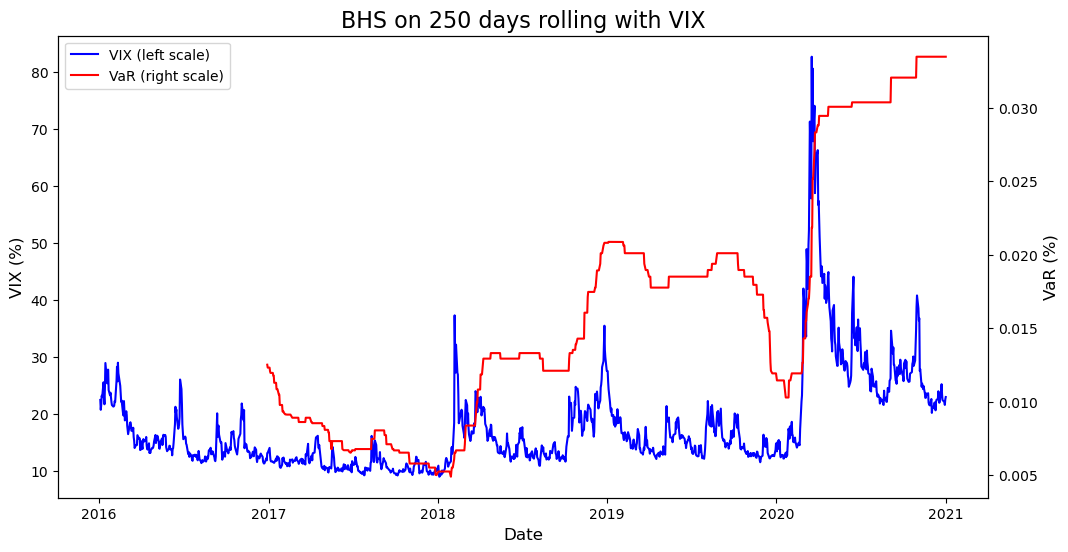

In [17]:
fig,ax=plt.subplots(nrows=1,ncols=1)
l1, = ax.plot(new_table['VIX Open'],color='blue')
plt.xlabel('Date',fontsize=12)
plt.ylabel('VIX (%)',fontsize=12)
plt.title('BHS on 250 days rolling with VIX',fontsize=16)
ax2=ax.twinx()
l2, = ax2.plot(new_table['VaR'],color='red')
ax2.set_ylabel('VaR (%)',fontsize=12)
plt.legend([l1, l2], ["VIX (left scale)", "VaR (right scale)"])
fig.set_size_inches(12, 6)

If we think the VIX index is a good measure of market risk then we can see around Jan 2018 that HS reacts too slowly and during Covid in Jan 2020 then after the intial spike it continues to increase and stay high when VIX goes back down. It takes 250 days for HS with a rolling window of 250 to "forget" an observation.

## Time weighted Historical Simulation (TWHS)


In [18]:
lambda_par = 0.98 
w = np.zeros(T)
print(w)

[0. 0. 0. ... 0. 0. 0.]


In [19]:
w[T-1] = (1-lambda_par)/(1-lambda_par**T) # Slide 8 Video lecture 6
print(w)

[0.   0.   0.   ... 0.   0.   0.02]


In [20]:
for j in range(1,T+1):
    w[j-1]=w[T-1]*lambda_par**(T-j)
print(sum(w)) # check so we got it right, w should sum to 1
#Put returns and weight together


1.0


In [21]:
our_sample.insert(3,"weights",w)
print(our_sample)

              vwretd    losses       VaR       weights
caldt                                                 
2016-01-04 -0.015190  0.015190       NaN  1.834143e-13
2016-01-05  0.002134 -0.002134       NaN  1.871575e-13
2016-01-06 -0.012566  0.012566       NaN  1.909770e-13
2016-01-07 -0.023433  0.023433       NaN  1.948745e-13
2016-01-08 -0.010898  0.010898       NaN  1.988515e-13
...              ...       ...       ...           ...
2020-12-24  0.003623 -0.003623  0.033469  1.844736e-02
2020-12-28  0.008938 -0.008938  0.033469  1.882384e-02
2020-12-29 -0.002240  0.002240  0.033469  1.920800e-02
2020-12-30  0.001475 -0.001475  0.033469  1.960000e-02
2020-12-31  0.006367 -0.006367  0.033469  2.000000e-02

[1259 rows x 4 columns]


In [22]:
sorted_tw_losses = our_sample.sort_values('losses', ascending=False)
print(sorted_tw_losses)

              vwretd    losses       VaR   weights
caldt                                             
2020-03-16 -0.118970  0.118970  0.018505  0.000338
2020-03-12 -0.095036  0.095036  0.017615  0.000324
2020-03-09 -0.075275  0.075275  0.016666  0.000305
2020-06-11 -0.058263  0.058263  0.030065  0.001159
2020-03-18 -0.050477  0.050477  0.021855  0.000352
...              ...       ...       ...       ...
2020-03-17  0.060242 -0.060242  0.021855  0.000345
2020-03-26  0.062088 -0.062088  0.028323  0.000397
2020-04-06  0.070015 -0.070015  0.029446  0.000457
2020-03-24  0.092646 -0.092646  0.028323  0.000381
2020-03-13  0.093205 -0.093205  0.018505  0.000331

[1259 rows x 4 columns]


Say we want to Calculate 99% Time weighted VaR, we then need to sum up weights until we get a probability of 1% (1-alpha)

In [23]:
alpha = 0.99
sum_w = 0
i = 0
while sum_w<(1-alpha):
    sum_w += sorted_tw_losses.iloc[i,3]
    i += 1
print("99% VaR is {:.4f}".format(sorted_tw_losses.iloc[i-1,1])) # Same principle as with BHS

99% VaR is 0.0352


In [24]:
print("99% ES is {:.4f}".format(np.mean(sorted_tw_losses.iloc[0:i-1,1]))) 

99% ES is 0.0576


You can of course use a rolling sample also with TWHS, you have to nest the while loop in the for loop so you probabiilty would like to make a function that calculates TWHS VaR and ES and then call that function


In [25]:
# Function for computing VaR by Time weighted historical simulation
# Input df of losses, weights and a VaR level (alpha)
def twhs_VaR(data,alpha):
    data = data.sort_values('losses', ascending=False)
    sum_w = 0
    i = 0
    while sum_w<(1-alpha):
        sum_w += data.iloc[i,1]
        i += 1
    return data.iloc[i-1,0]

print("Trying function {:.4f}".format(twhs_VaR(our_sample[['losses','weights']],0.99)))

Trying function 0.0352


In [26]:
# Function for computing ES by Time weighted historical simulation
# Input df of losses, weights and an ES level (alpha)
def twhs_ES(data,alpha):
    data = data.sort_values('losses', ascending=False)
    sum_w = 0
    i = 0
    while sum_w<(1-alpha):
        sum_w += data.iloc[i,1]
        i += 1
    return np.mean(data.iloc[0:i-1,0])

print("Trying function {:.4f}".format(twhs_ES(our_sample[['losses','weights']],0.99)))
our_sample.insert(4,"twhs_VaR",np.nan)

Trying function 0.0576


In [27]:
w = np.zeros(rT)
w[rT-1] = (1-lambda_par)/(1-lambda_par**rT)

for j in range(1,rT+1):
    w[j-1]=w[rT-1]*lambda_par**(rT-j)

for j in range(rT,T): # Pick j from 250 up to T
    roll_sample = our_sample.iloc[j-(rT-1):j+1,1].to_frame()
    roll_sample.insert(1,'weights',w)
    our_sample.iloc[j,4] = twhs_VaR(roll_sample,0.95)

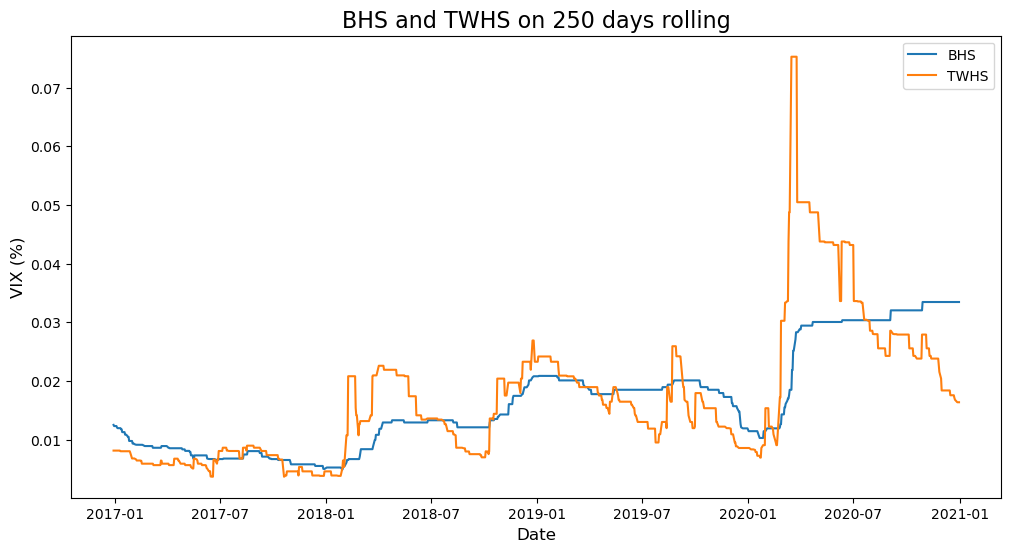

In [28]:

fig,ax=plt.subplots()
ax.plot(our_sample['VaR'],label='BHS')
ax.plot(our_sample['twhs_VaR'],label='TWHS')

plt.xlabel('Date',fontsize=12)
plt.ylabel('VIX (%)',fontsize=12)
plt.title('BHS and TWHS on 250 days rolling',fontsize=16)
plt.legend()
fig.set_size_inches(12, 6)

As  you can see in the graph, TWHS responds much more rapidly to changes in market conditions
## Volatility Weighted Historical Simulation (VWHS)
For this method we need to construct volatility from t=1 to t=T+1 if T is our sample size.
We start by using the EWMA model which is a special case of a GARCH(1,1) .The code follows Slide 22 of Video Lecture 6

In [29]:
eta = our_sample.losses # Setting innovation equal to Loss is ok since daily returns close to zero and hard to predict
sigma = [np.var(eta)] # Sigma_0 in slides
lambda_par = 0.94 # RiskMetrics

for j in range(1,T+1):
    sigma.append((1-lambda_par)*eta[j-1]**2+lambda_par*sigma[j-1])

sigma = np.array(sigma)
annualized_percent_vol = (250*sigma)**0.5
    

Text(0.5, 1.0, 'Volatility from EWMA model')

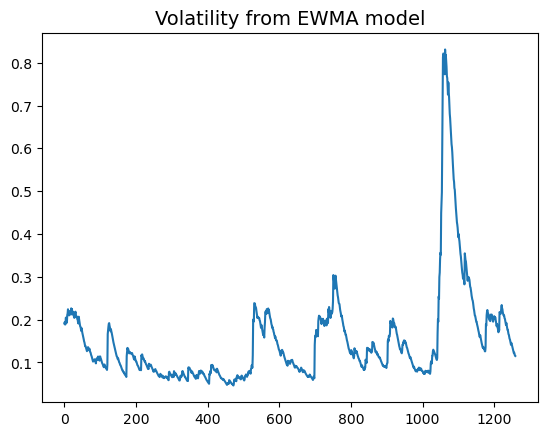

In [30]:
fig,ax=plt.subplots()
ax.plot(annualized_percent_vol)
plt.title('Volatility from EWMA model',fontsize=14)

In [31]:
scaledLosses = our_sample.losses/np.sqrt(sigma[0:T])*np.sqrt(sigma[T]) # Slide 8 lecture 3


We can now calculate VaR and ES exactly as we did with BHS

In [32]:
vw_VaR95 = np.quantile(scaledLosses,0.95)
print("Volatlity weighted 95% VaR is {:.4f}".format(vw_VaR95))

Volatlity weighted 95% VaR is 0.0116


In [33]:
vw_ES95 = np.mean(scaledLosses[scaledLosses>vw_VaR95])
print("Volatlity weighted 95% ES is {:.4f}".format(vw_ES95))

Volatlity weighted 95% ES is 0.0201


Since our forecas of volatility for T+2 will be different from T+1 VWHS produces time varying VaR and ES. We can illustrate this by changing the endpoint T of the sample. Here I used what is called forecasting on a recursive sample, that is the sample becomes bigger when we move forward in time.

In [34]:

vwVaR95 = []
for i in range(-249,1): # Do VaR for 250 days
    sigma = [np.var(eta)]
    for j in range(1,T+i+1):
        sigma.append((1-lambda_par)*eta[j-1]**2+lambda_par*sigma[j-1])
    scaledLosses = (our_sample.losses[0:T+i]/np.sqrt(np.array(sigma[0:T+i])))*np.sqrt(sigma[T+i])
    vwVaR95.append(np.quantile(scaledLosses,0.95))


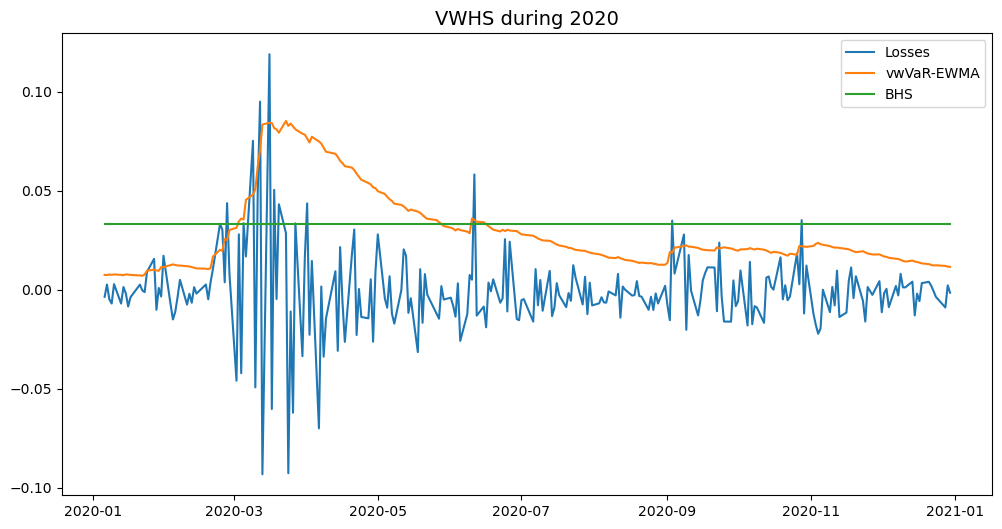

In [35]:

new_df = our_sample.losses[len(our_sample.losses)-251:-1].to_frame()
new_df.insert(1,'vwVaR95',np.array(vwVaR95))
new_df.insert(2,'BHS',np.quantile(our_sample.losses[len(our_sample.losses)-251:-1],0.95)*np.ones(250))
fig,ax=plt.subplots()
ax.plot(new_df)
plt.title('VWHS during 2020',fontsize=14)
ax.legend(['Losses','vwVaR-EWMA','BHS'])
fig.set_size_inches(12, 6)

## VWHS using the VIX index (Nossman and Vilhelmsson, 2014)
This method does not require a model to construct volatility, we take the VIX series as our volatility estimate. First we put VIX and our Losses in a new dataframe

In [36]:
df_vix_sample = new_table[['losses','VIX Open']]
print(df_vix_sample)

              losses   VIX Open
2016-01-04  0.015190  22.480000
2016-01-05 -0.002134  20.750000
2016-01-06  0.012566  21.670000
2016-01-07  0.023433  23.219999
2016-01-08  0.010898  22.959999
...              ...        ...
2020-12-24 -0.003623  22.469999
2020-12-28 -0.008938  22.110001
2020-12-29  0.002240  21.610001
2020-12-30 -0.001475  22.580000
2020-12-31 -0.006367  22.990000

[1259 rows x 2 columns]


In [37]:
scaled_losses = (df_vix_sample.losses/df_vix_sample['VIX Open'])*df_vix_sample['VIX Open'][-1]
df_vix_sample.insert(2,'scaled_losses',scaled_losses)

In [38]:
print(df_vix_sample)

              losses   VIX Open  scaled_losses
2016-01-04  0.015190  22.480000       0.015535
2016-01-05 -0.002134  20.750000      -0.002364
2016-01-06  0.012566  21.670000       0.013331
2016-01-07  0.023433  23.219999       0.023201
2016-01-08  0.010898  22.959999       0.010912
...              ...        ...            ...
2020-12-24 -0.003623  22.469999      -0.003707
2020-12-28 -0.008938  22.110001      -0.009294
2020-12-29  0.002240  21.610001       0.002383
2020-12-30 -0.001475  22.580000      -0.001502
2020-12-31 -0.006367  22.990000      -0.006367

[1259 rows x 3 columns]


Now we use BHS on the scaledLosses so our T+1 forecast for 95% VaR is

In [39]:
print('{:.4f}'.format(np.quantile(df_vix_sample.scaled_losses,0.95)))

0.0184


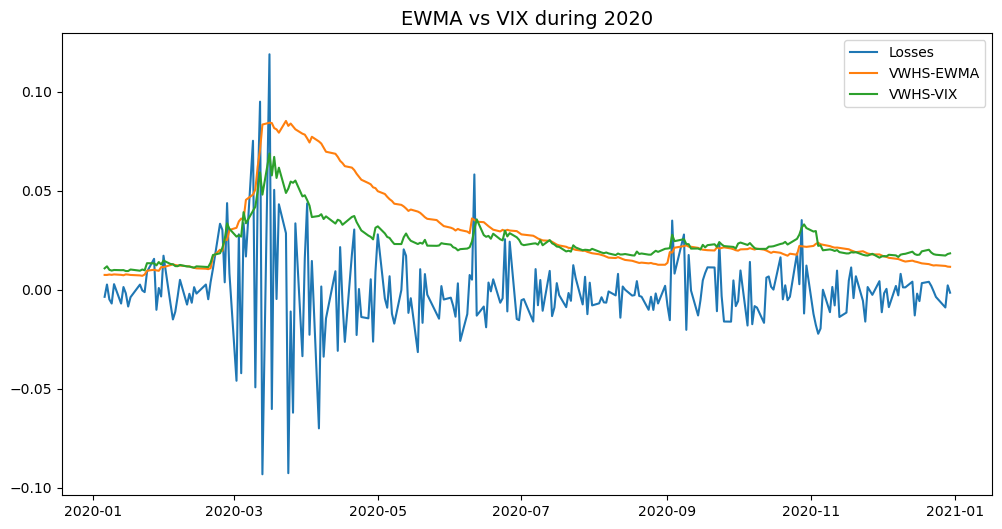

In [40]:
# Let's compute VIX-VaR for 2020
vix_VaR95 = []
for i in range(-250,0): # Do VaR for 250 days
    scaledLosses = (our_sample.losses[0:T+i]/df_vix_sample['VIX Open'][0:T+i])*df_vix_sample['VIX Open'][T+i]
    vix_VaR95.append(np.quantile(scaledLosses,0.95))
new_df = df_vix_sample['losses'][len(our_sample.losses)-251:-1].to_frame()
new_df.insert(1,'VWHS-EWMA',np.array(vwVaR95))
new_df.insert(2,'VWHS-VIX',np.array(vix_VaR95))
fig,ax=plt.subplots()
ax.plot(new_df)
plt.title('EWMA vs VIX during 2020',fontsize=14)
ax.legend(['Losses','VWHS-EWMA','VWHS-VIX'])
fig.set_size_inches(12, 6)

In [41]:
print('Max VaR from EWMA is {:.2f}%, max VaR from VIX is {:.2f}%'.format(max(vwVaR95)*100,max(vix_VaR95)*100))

Max VaR from EWMA is 8.53%, max VaR from VIX is 6.89%
